In [1]:
import warnings
from pathlib import Path
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
results_dir = Path("../2.evalzoo/results/")
mertrics_filename = "metrics_level_1_ref"

metrics_columns = [
    "sim_retrieval_average_precision_ref_i_mean_i",
    "sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i",
    "sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i"
    ]

metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset": {
        "same_well_diff_pert": "0e4cd68f",
        "same_pert_diff_well": "ceb5f02a",
        "same_well_same_pert": "34fbd8a4",
    },
    # subset -> correct -> robustMAD -> feature select -> metrics
    "subset_corrected": {
        "same_well_diff_pert": "82ad004e",
        "same_pert_diff_well": "f5c36cb4",
        "same_well_same_pert": "d66f1bce",
    },
}


In [3]:
metrics_dfs = []

for subset, configs in metrics.items():
    for config, config_dir in configs.items():
        metrics_path = results_dir / config_dir / f"{mertrics_filename}.parquet"
        metrics_df = pd.read_parquet(metrics_path, columns=metrics_columns)
        metrics_df.columns = ["mAP", "-log(pvalue)", "-log(qvalue)"]
        metrics_df["config"] = config
        metrics_df["subset"] = subset
        metrics_df["p<0.05"] = metrics_df["-log(pvalue)"] > 1.3
        metrics_dfs.append(metrics_df)

In [4]:
metrics_df = pd.concat(metrics_dfs, axis=0)
metrics_df.shape

(14760, 6)

same_well_diff_pert subset mmAP: 0.064 p<0.05: 0.144 (527/3653)
same_well_diff_pert subset_corrected mmAP: 0.0602 p<0.05: 0.0361 (132/3653)


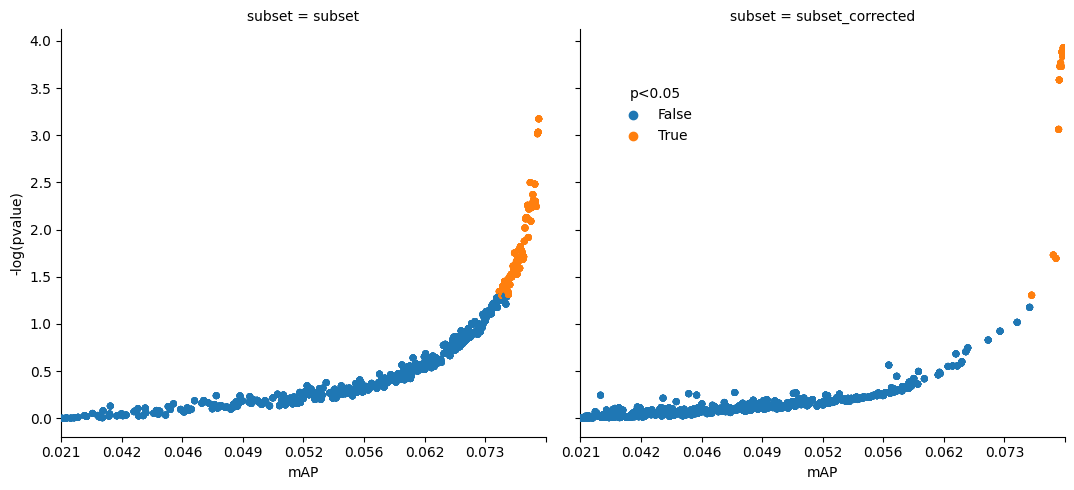

same_pert_diff_well subset mmAP: 0.00961 p<0.05: 0.0 (0/74)
same_pert_diff_well subset_corrected mmAP: 0.0135 p<0.05: 0.0 (0/74)


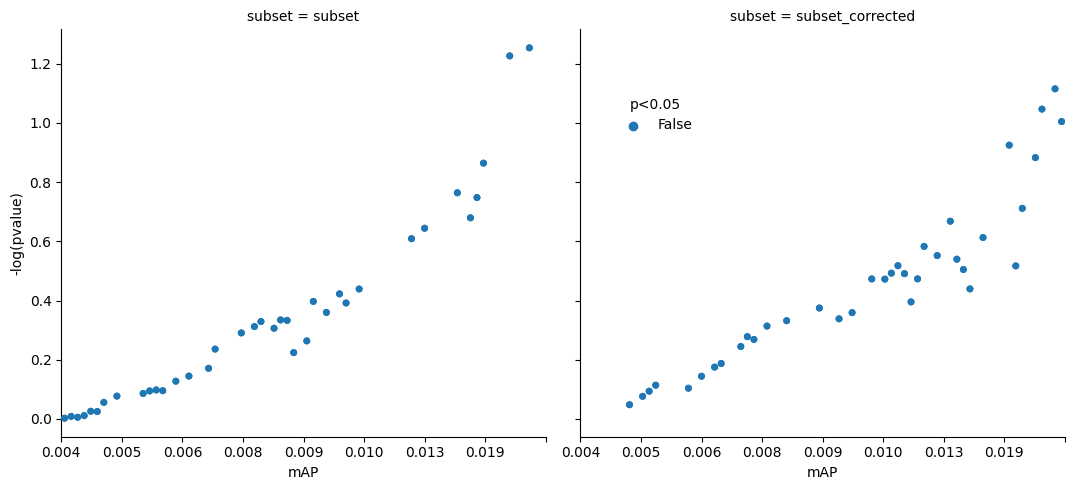

same_well_same_pert subset mmAP: 0.197 p<0.05: 0.902 (3295/3653)
same_well_same_pert subset_corrected mmAP: 0.165 p<0.05: 0.775 (2831/3653)


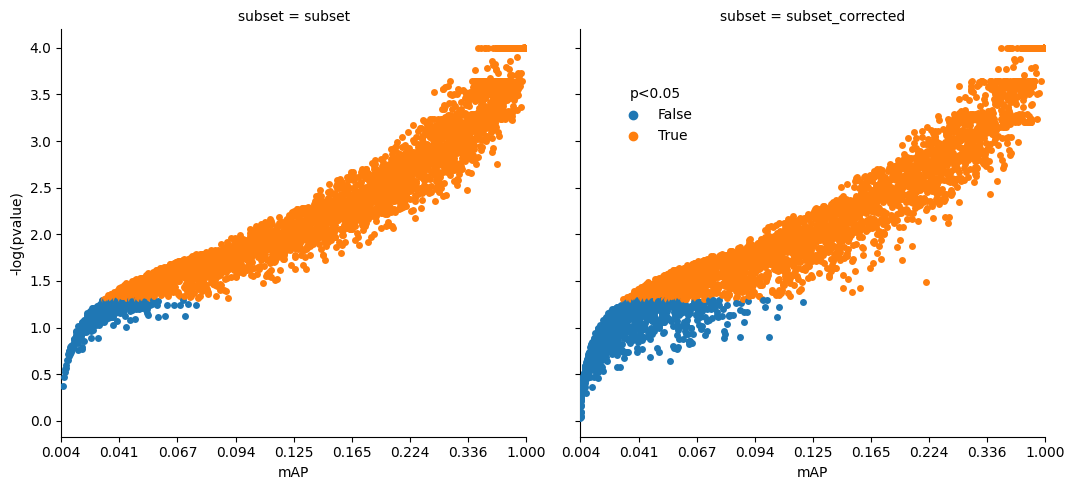

In [5]:
def fmt(s):
    try:
        n = f"{float(s):.3f}"
    except:
        n = ""
    return n

for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    for subset in config_df.subset.unique():
        p_value = config_df[config_df.subset==subset]['p<0.05']
        print(
            config,
            subset,
            f"mmAP: {config_df[config_df.subset==subset].mAP.mean():.03}",
            f"p<0.05: {p_value.mean():.03} ({p_value.sum()}/{p_value.shape[0]})",
            )
    g = sns.catplot(data=config_df, x="mAP", y="-log(pvalue)", col="subset", hue="p<0.05", jitter=False, legend_out=False)
    g._legend.set_bbox_to_anchor((.65, .75))
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(ticker.LinearLocator(9))
        ax.set_xticklabels([fmt(label.get_text()) for label in ax.get_xticklabels()])
        # axes.set_xlim(0.0, 1.0)
    plt.tight_layout()
    plt.show()